In [4]:
import pandas as pd
import numpy as np
import panel as pn
import matplotlib.pyplot as plt
import os,sys
from clickhouse_driver import connect,Client
from pprint import pprint
import yaml

pn.extension()
pn.extension('tabulator')

# load `.env`
with open(".env") as f:
	for line in [line for line in f  if not line.startswith('#') and line.strip()]:
		key, value = line.strip().split('=', 1)
		os.environ[key]=value
  
client=Client(host= os.environ["CLICKHOUSE_HOST"], 
              port=str(os.environ["CLICKHOUSE_PORT"]), 
              user=os.environ["CLICKHOUSE_USER"], 
              password=os.environ["CLICKHOUSE_PASSWORD"], 
              secure= os.environ["CLICKHOUSE_SECURE"])

print("Clickhouse connected")

Clickhouse connected


In [5]:
%%time
catalogs = client.execute("""
SELECT catalog, SUM(tot_size) as tot_size, SUM(num_files) as num_files
FROM nsdf.aggregated_catalog 
GROUP BY catalog 
ORDER by tot_size DESC
""")

CPU times: user 3.82 ms, sys: 3.21 ms, total: 7.03 ms
Wall time: 247 ms


In [6]:
def ShowRecords(records, titles={}):
	df=pd.DataFrame(records)
	if titles: titles={ I : titles[I] for I in range(len(titles)) }
	print(titles)
	df_widget = pn.widgets.Tabulator(df, hidden_columns=["index"], titles=titles,page_size =10,pagination ="local")

	return df_widget

ShowRecords(catalogs,["catalog","tot_size","num_files"])

{0: 'catalog', 1: 'tot_size', 2: 'num_files'}


Tabulator(hidden_columns=['index'], page_size=10, pagination='local', titles={0: 'catalog', ...}, value=              ...)

In [7]:
%%time

# total records and total size
NUM_FILES,TOT_BYTES=client.execute(f"SELECT SUM(num_files),SUM(tot_size) FROM nsdf.aggregated_catalog;")[0]
print(f"{NUM_FILES:,} TOT_BYTES={TOT_BYTES:,}")

1,590,981,170 TOT_BYTES=84,795,345,554,398,043
CPU times: user 1.5 ms, sys: 1.25 ms, total: 2.75 ms
Wall time: 106 ms


In [10]:
%%time

# # total size per catalog/bucket
ShowRecords(client.execute("""
	SELECT catalog,bucket, SUM(num_files) as num_files,SUM(tot_size) as tot_size
	FROM nsdf.aggregated_catalog
	GROUP BY catalog, bucket
	ORDER BY tot_size DESC,num_files DESC
	LIMIT 100
	"""))

{}
CPU times: user 7.88 ms, sys: 0 ns, total: 7.88 ms
Wall time: 589 ms


Tabulator(hidden_columns=['index'], page_size=10, pagination='local', value=              ...)

In [16]:
%%time

# example of looking to a specific catalog,bucket
ShowRecords(client.execute("""
	SELECT catalog,SUM(tot_size) as tot_size, SUM(num_files) as num_files
	FROM nsdf.aggregated_catalog 
	WHERE catalog='aws-open-data' and bucket='noaa-cors-pds'
	GROUP BY catalog
"""))

{}
CPU times: user 4.22 ms, sys: 0 ns, total: 4.22 ms
Wall time: 101 ms


Tabulator(hidden_columns=['index'], page_size=10, pagination='local', value=              ...)

In [17]:
%%time

# LIKE query for looking into filenames (Need to scan the whole dataset)
ShowRecords(client.execute("""
	SELECT count(*) from nsdf.catalog
	WHERE name like '%aaaa%'
"""))

{}
CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 48.2 s


Tabulator(hidden_columns=['index'], page_size=10, pagination='local', value=        0
0  250251)

In [21]:
%%time

# tot_size per catalog
ShowRecords(client.execute("""
	SELECT catalog, SUM(tot_size) as tot_size
	FROM nsdf.aggregated_catalog
	GROUP BY catalog
	ORDER by tot_size DESC
"""),titles=["catalog", "tot_size"])

{0: 'catalog', 1: 'tot_size'}
CPU times: user 0 ns, sys: 4.44 ms, total: 4.44 ms
Wall time: 118 ms


Tabulator(hidden_columns=['index'], page_size=10, pagination='local', titles={0: 'catalog', ...}, value=              ...)

In [26]:
%%time

# size per catalog,bucket
ShowRecords(client.execute("""
	SELECT catalog, bucket, SUM(tot_size) as tot_size
	FROM nsdf.aggregated_catalog
	GROUP BY catalog, bucket
	ORDER BY tot_size DESC
 LIMIT 100
"""))

{}
CPU times: user 8.53 ms, sys: 0 ns, total: 8.53 ms
Wall time: 600 ms


Tabulator(hidden_columns=['index'], page_size=10, pagination='local', value=              ...)

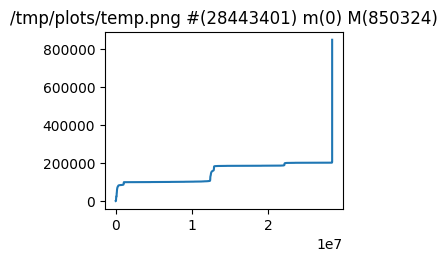

CPU times: user 8.57 s, sys: 2.59 s, total: 11.2 s
Wall time: 13.9 s


In [27]:
%%time

def PlotSizes(filename, sizes, W=1024*0.3,H=768*0.3):
	ipd = 1/plt.rcParams['figure.dpi'] 
	plt.figure(figsize=(W*ipd,H*ipd))
	plt.title(f"{filename} #({len(sizes)}) m({sizes[0]}) M({sizes[-1]})")
	plt.plot(range(len(sizes)), sorted(sizes))
	os.makedirs(os.path.dirname(filename),exist_ok=True)
	plt.savefig(filename)
	plt.show()

sizes=[int(it[0]) for it in client.execute("SELECT size from nsdf.catalog where catalog='aws-open-data' and bucket='streaming-orcasound-net' ORDER BY size ASC")]
PlotSizes(filename=f"/tmp/plots/temp.png",sizes=sizes)